# Zonal structure of time-mean Zonal Mean Stress (Taux) in the equatorial Pacific


# Datasets Used for Zonal Mean Stress Comparison

The following reference observational datasets are used to evaluate the model simulations:

- **ERA5-Interim**


## To Do

- CMAP not available on Gadi

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tauu',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
 "ERA-Interim": 
     Dataset(
     short_name='tauu',
     dataset='ERA-Interim',
     mip="Amon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=3)
}



In [3]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

 tauu: attribute positive not present
loaded from file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/tauu/gn/v20191115/tauu_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc
 tauu: attribute positive not present
loaded from file 


In [4]:
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics

In [14]:
def prepoc1(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

def prepoc2(cube):
    nino3_latext_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **nino3_latext_region)
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = axis_statistics(cube, operator="mean", axis="y")
    cube = convert_units(cube, units="1e-3 N/m2")
    return cube

In [15]:
model_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: prepoc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: prepoc2(dataset) for name, dataset in obs_datasets.items()}

# Diagnostics Level 1


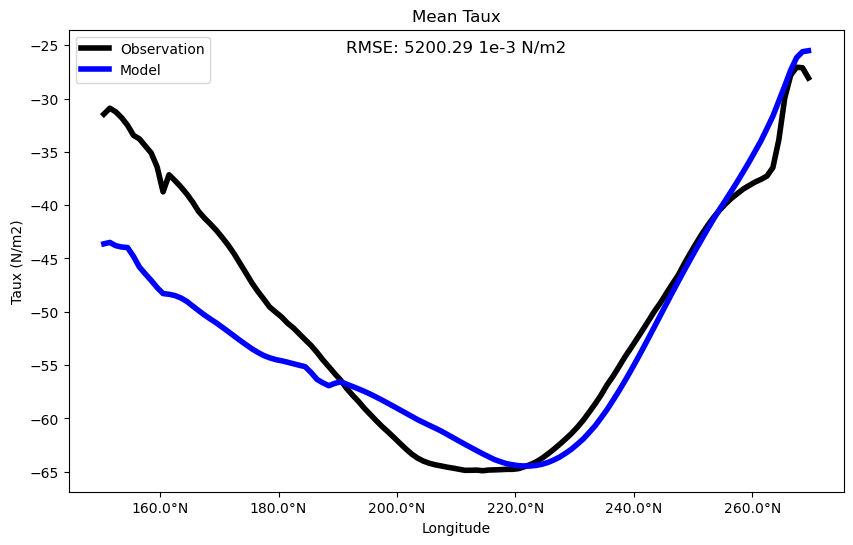

In [16]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_latitude(x, pos):
    if x < 0:
        return f'{abs(x)}°S'
    elif x > 0:
        return f'{x}°N'
    else:
        return '0°'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep2["ERA-Interim"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Taux (N/m2)')
plt.title('Mean Taux')

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} 1e-3 N/m2', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_latitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

# Diagnostics Level 2


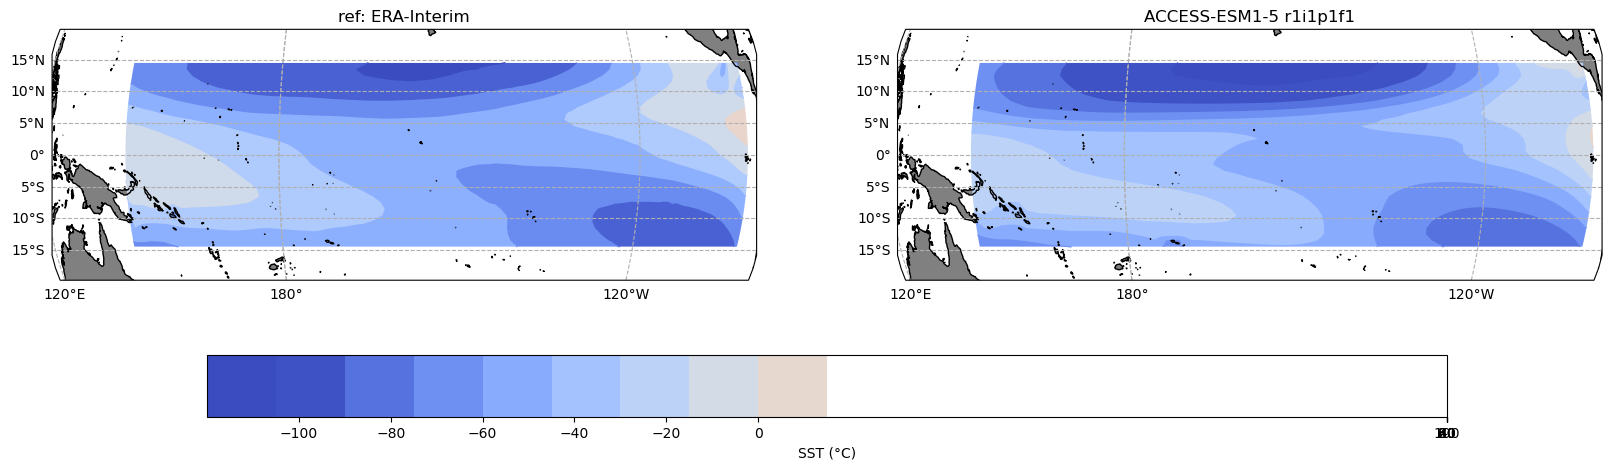

In [30]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep1["ERA-Interim"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Use the coolwarm colormap
cmap = plt.get_cmap('coolwarm')

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of -100 to 100
norm = mcolors.Normalize(vmin=-100, vmax=100)

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ref: ERA-Interim")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
# NOTE: The colorbar will be based on cf2, which already has the correct normalization applied.
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('SST (°C)')
#cbar.set_clim(-100, 100)
#cbar.set_ticks(np.linspace(-100, 100, num=11))  # Set ticks ranging from -100 to 100

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()
